# Mercari Price Suggestion Project
## Introduction
This project is a Explanatory Data Analysis of the price suggestion data from Mercari. Mercari is the biggest Japanese community-powered shopping app. The goal of this project is to predict the price of the items listed by sellers on Mercari, given its information (item condition, category, brand, text description, shipping cost). 

In [1]:
import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
train = pd.read_csv(f'/Users/nzhang/OneDrive/Data/Mercari/train.tsv', sep='\t')
test = pd.read_csv(f'/Users/nzhang/OneDrive/Data/Mercari/test.tsv', sep='\t')

In [3]:
print(train.shape, test.shape)

(1482535, 8) (693359, 7)


In [4]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
train_id             1482535 non-null int64
name                 1482535 non-null object
item_condition_id    1482535 non-null int64
category_name        1476208 non-null object
brand_name           849853 non-null object
price                1482535 non-null float64
shipping             1482535 non-null int64
item_description     1482531 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


We get some missing values in category_name and brand_name. We will need to deal with the nulls in our later analysis.

## Exploratory Data Analysis
### Target Variable: Price

#### *Remove low prices*
Mercari does not allow items lower than $3 to be posted, so we assume those one are errors. Removing them will help the model.

In [6]:
train = train.drop(train[(train.price < 3)].index)
train.shape

(1481661, 8)

In [7]:
train.columns

Index(['train_id', 'name', 'item_condition_id', 'category_name', 'brand_name',
       'price', 'shipping', 'item_description'],
      dtype='object')

In [8]:
test.columns

Index(['test_id', 'name', 'item_condition_id', 'category_name', 'brand_name',
       'shipping', 'item_description'],
      dtype='object')

In [9]:
train.price.describe()

count    1.481661e+06
mean     2.675329e+01
std      3.859198e+01
min      3.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

Note: The range of price is from $3 to $2009

/Users/nzhang/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


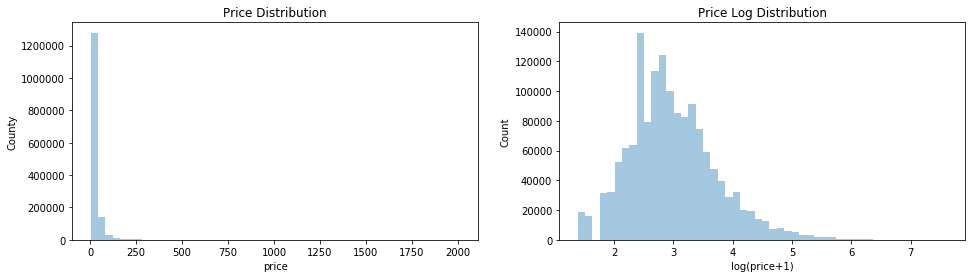

In [10]:
train['log_price'] = np.log(train['price'] + 1)

plt.figure(figsize=(16,4))

plt.subplot('121')
sns.distplot(train['price'], bins=50, kde=False)
plt.xlabel('price')
plt.ylabel('County')
plt.title('Price Distribution')

plt.subplot('122')
sns.distplot(train['log_price'], bins=50, kde=False)
plt.xlabel('log(price+1)')
plt.ylabel('Count')
plt.title('Price Log Distribution')

plt.show()

Note: the distribution is left skewed, so we take the log of price to get a more normal distribution.

### Categorical Variable - Shipping Cost

In [11]:
train.shipping.value_counts()/len(train)

0    0.552674
1    0.447326
Name: shipping, dtype: float64

Note: 55% of shipping costs are paid by sellers.

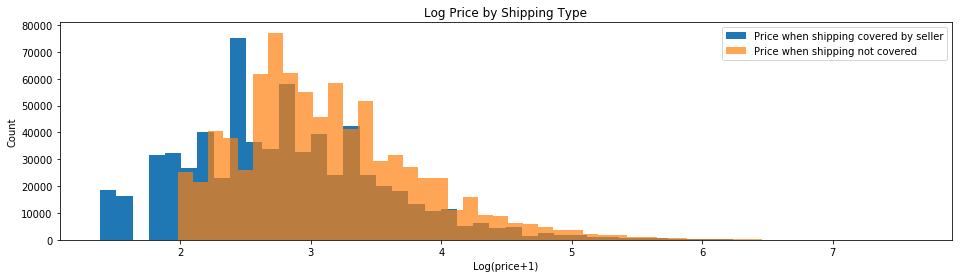

In [12]:
fig, ax = plt.subplots(figsize=(16,4))
ax.hist(train.log_price[train.shipping==1], alpha=1.0, bins=50, label='Price when shipping covered by seller')
ax.hist(train.log_price[train.shipping==0], alpha=0.7, bins=50, label='Price when shipping not covered')
plt.xlabel('Log(price+1)')
plt.ylabel('Count')
plt.title('Log Price by Shipping Type')
plt.legend()
plt.show()

Note: Prices are higher when shipping are not covered. Probably because buyers that buy more expensive items care less about shipping cost.

###  Categorical Variable - Item Condition

There are five levels of item conditions, from 1 to 5.

In [13]:
train.groupby('item_condition_id')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
item_condition_id,,,,,,,,
1,640246.0,26.499502,35.421715,3.0,10.0,18.0,30.00,2009.0
2,375196.0,27.584015,42.134777,3.0,11.0,17.0,29.00,2004.0
3,431892.0,26.557241,40.037663,3.0,11.0,16.0,28.00,2000.0
4,31945.0,24.362169,35.684218,3.0,10.0,15.0,26.00,1309.0
5,2382.0,31.730479,39.536983,3.0,11.0,19.0,35.75,522.0


The standard deviations of prices for each item condition are significant, compared with their means.

/Users/nzhang/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


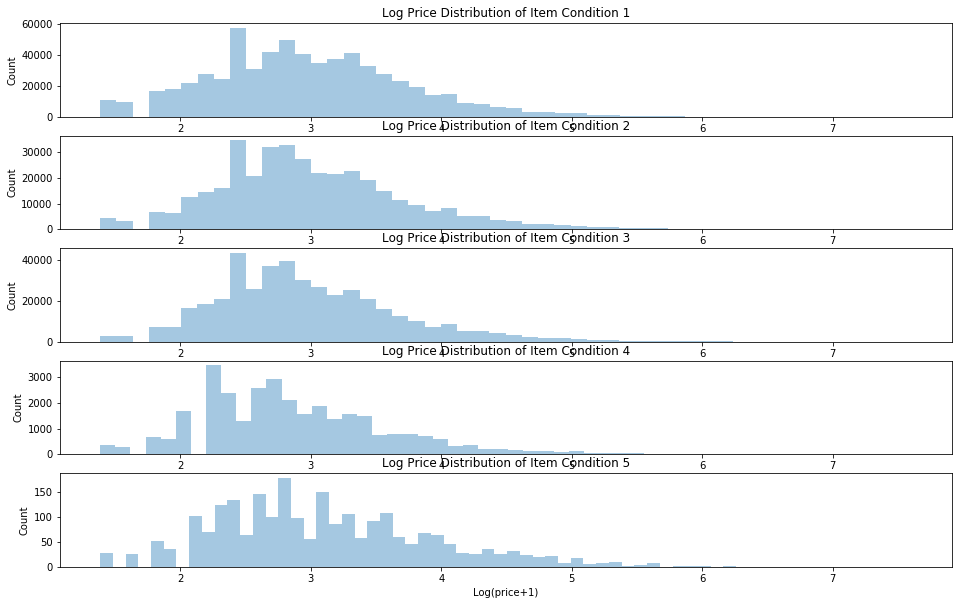

In [14]:
fig = plt.figure(figsize=(16,10))

ax1 = plt.subplot('511')
sns.distplot(train.log_price[train.item_condition_id==1], bins=50, kde=False, ax=ax1)
ax1.set_xlabel('')
ax1.set_ylabel('Count')
ax1.set_title("Log Price Distribution of Item Condition 1")

ax2 = plt.subplot('512', sharex=ax1)
sns.distplot(train.log_price[train.item_condition_id==2], bins=50, kde=False, ax=ax2)
ax2.set_xlabel('')
ax2.set_ylabel('Count')
ax2.set_title("Log Price Distribution of Item Condition 2")

ax3 = plt.subplot('513', sharex=ax1)
sns.distplot(train.log_price[train.item_condition_id==3], bins=50, kde=False, ax=ax3)
ax3.set_xlabel('')
ax3.set_ylabel('Count')
ax3.set_title("Log Price Distribution of Item Condition 3")

ax4 = plt.subplot('514', sharex=ax1)
sns.distplot(train.log_price[train.item_condition_id==4], bins=50, kde=False, ax=ax4)
ax4.set_xlabel('')
ax4.set_ylabel('Count')
ax4.set_title("Log Price Distribution of Item Condition 4")

ax5 = plt.subplot('515', sharex=ax1)
sns.distplot(train.log_price[train.item_condition_id==5], bins=50, kde=False, ax=ax5)
ax5.set_xlabel('Log(price+1)')
ax5.set_ylabel('Count')
ax5.set_title("Log Price Distribution of Item Condition 5")

plt.show()

As we can see, the item conditions 1 - 4 do not make much difference on item price, the prices of item condition 5 has a larger variance.

### Categorical/Text Variable - Item Category

In [15]:
print("There are %d unique values in the category column." % train['category_name'].nunique())

There are 1287 unique values in the category column.


In [16]:
# TOP 5 RAW CATEGORIES
train['category_name'].value_counts()[:10]

Women/Athletic Apparel/Pants, Tights, Leggings                 60152
Women/Tops & Blouses/T-Shirts                                  46349
Beauty/Makeup/Face                                             34320
Beauty/Makeup/Lips                                             29901
Electronics/Video Games & Consoles/Games                       26547
Beauty/Makeup/Eyes                                             25200
Electronics/Cell Phones & Accessories/Cases, Covers & Skins    24668
Women/Underwear/Bras                                           21254
Women/Tops & Blouses/Tank, Cami                                20270
Women/Tops & Blouses/Blouse                                    20269
Name: category_name, dtype: int64

It does not surprise me that the Women and Beauty categories have large numbers of listings.

In [17]:
# missing categories
print("There are %d items that do not have a label." % train['category_name'].isnull().sum())

There are 6314 items that do not have a label.


In [18]:
# A function to split category into general and subcategories and to handle missing labels
def split_cat(text):
    try: return text.split("/")
    except: return ("No Label", "No Label", "No Label")

In [19]:
train['general_cat'], train['subcat_1'], train['subcat_2'] = zip(*train['category_name'].apply(split_cat))
test['general_cat'], test['subcat_1'], test['subcat_2'] = zip(*test['category_name'].apply(split_cat))

train['general_cat'].fillna(value="missing", inplace=True)
test['general_cat'].fillna(value="missing", inplace=True)

print("There are %d unique general categories." % train['general_cat'].nunique())
print("There are %d unique primary sub-categories." % train['subcat_1'].nunique())
print("There are %d unique secondary sub-categories." % train['subcat_2'].nunique())

There are 11 unique general categories.
There are 114 unique primary sub-categories.
There are 871 unique secondary sub-categories.


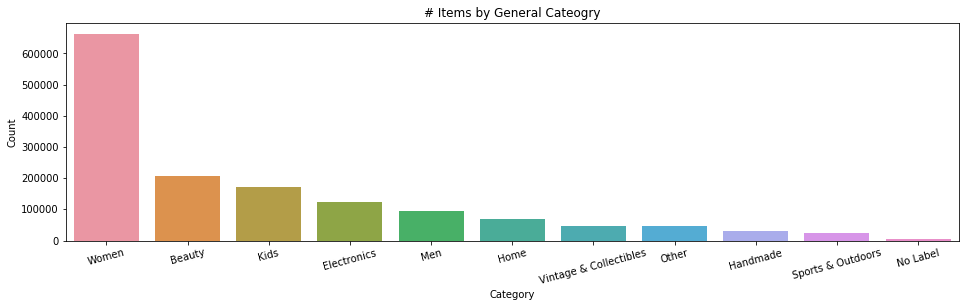

In [20]:
cat_count = train['general_cat'].value_counts()

plt.figure(figsize=(16,4))
sns.barplot(cat_count.index, cat_count.values)
plt.xlabel('Category')
plt.xticks(rotation=15) 
plt.ylabel('Count')
plt.title('# Items by General Cateogry')
plt.show()

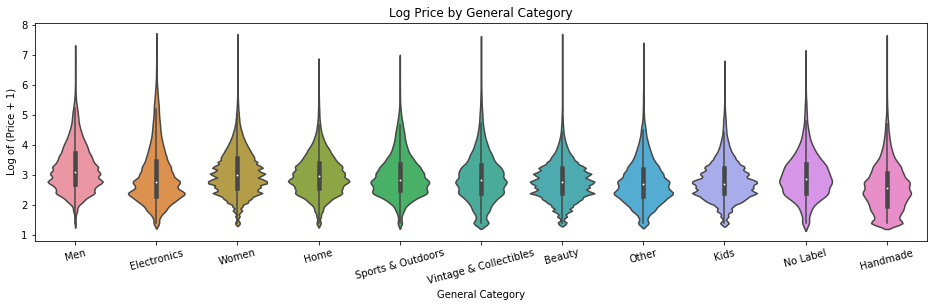

In [21]:
plt.figure(figsize=(16,4))
sns.violinplot(train.general_cat, np.log(train.price+1))
plt.xlabel('General Category')
plt.ylabel('Log of (Price + 1)')
plt.title('Log Price by General Category')
plt.xticks(rotation=15)
plt.show()

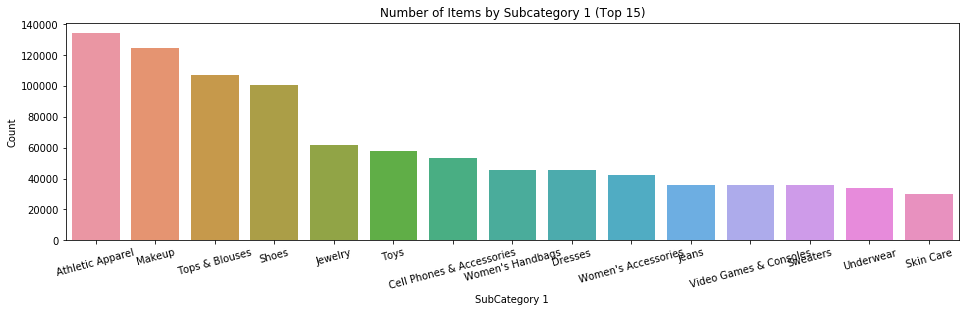

In [22]:
sub_count = train['subcat_1'].value_counts()

plt.figure(figsize=(16,4))
sns.barplot(sub_count.index[:15], sub_count.values[:15])
plt.xlabel('SubCategory 1')
plt.xticks(rotation=15) 
plt.ylabel('Count')
plt.title('Number of Items by Subcategory 1 (Top 15)')
plt.show()

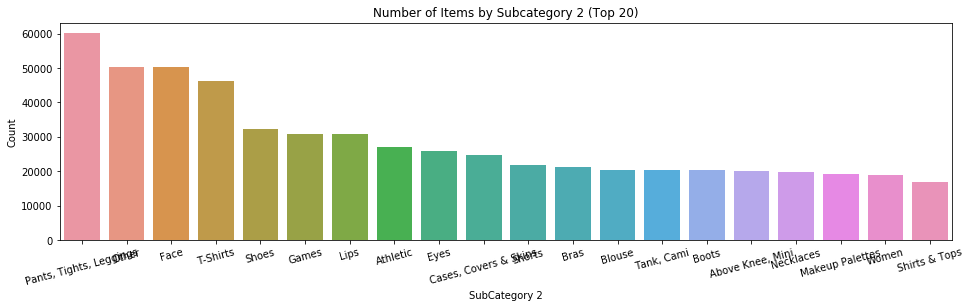

In [23]:
sub2_count = train['subcat_2'].value_counts()

plt.figure(figsize=(16,4))
sns.barplot(sub2_count.index[:20], sub2_count.values[:20])
plt.xlabel('SubCategory 2') 
plt.ylabel('Count')
plt.title('Number of Items by Subcategory 2 (Top 20)')
plt.xticks(rotation=15)
plt.show()

### Categorical/Text Variable - Brands

In [24]:
train.brand_name.fillna(value="missing", inplace=True)
test.brand_name.fillna(value="missing", inplace=True)

In [25]:
print("There are %d unique brand names in the training dataset." % train['brand_name'].nunique())

There are 4808 unique brand names in the training dataset.


#### *Brand diversity of category*

In [26]:
train.groupby(by=['general_cat', 'subcat_1','subcat_2']).\
    agg({"brand_name": pd.Series.nunique}).\
    sort_values(by='brand_name', ascending=False).head(10)

brand_name
general_cat subcat_1         subcat_2                    
Women       Tops & Blouses   Blouse                   661
No Label    No Label         No Label                 605
Women       Tops & Blouses   T-Shirts                 594
            Dresses          Above Knee, Mini         594
                             Knee-Length              562
            Tops & Blouses   Tank, Cami               529
Men         Tops             T-shirts                 493
Women       Shoes            Boots                    465
                             Sandals                  436
            Athletic Apparel Shorts                   428

#### *Brand frequency of listings*

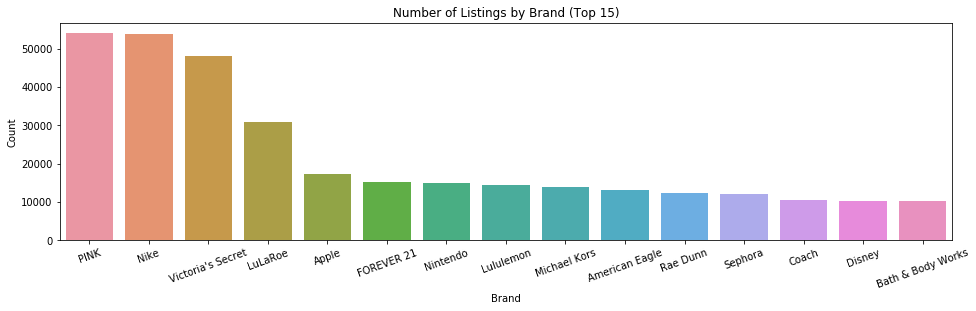

In [27]:
brand_count = train['brand_name'].value_counts().drop('missing')

plt.figure(figsize=(16,4))
sns.barplot(brand_count.index[:15], brand_count.values[:15])
plt.xlabel('Brand')
plt.ylabel('Count')
plt.title('Number of Listings by Brand (Top 15)')
plt.xticks(rotation=20)
plt.show()

Many of the top sellers are from Women and Electronics category. The brands will be a useful feature of determining price level in each category. Lateron, we can include brands in a random forest model.

#### *Brands in Same Category*
Let's dig into the Women/Tops & Blouses/Blouse to see how brands affect prices.

In [28]:
blouse = train[(train.general_cat == 'Women') & (train.subcat_1 == 'Tops & Blouses') & \
      (train.subcat_2 == 'Blouse')].copy()
blouse['log_price'] = np.log(blouse['price']+1) # Take log of prices
blouse.brand_name.fillna('Missing', inplace=True) # Fill null brand_names

# Keep only brands w/ more than 10 items
brand_items = np.unique(blouse.brand_name, return_counts=True)
popular_brands = brand_items[0][brand_items[1] >= 10]

# Find brands with highest & lowest means
popular_items = blouse[blouse.brand_name.isin(popular_brands)]

ordered_brands = popular_items.groupby(by='brand_name')['log_price'].mean().sort_values()
lowest_brands = ordered_brands[:6].index.tolist()
highest_brands = ordered_brands[-6:].index.tolist()

highest = blouse[blouse.brand_name.isin(highest_brands)]
lowest = blouse[blouse.brand_name.isin(lowest_brands)]

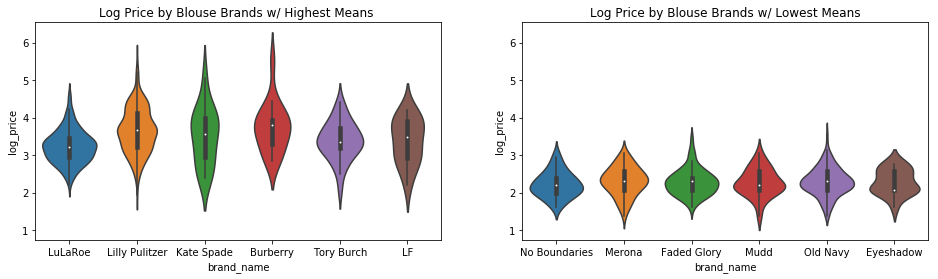

In [29]:
plt.figure(figsize=(16,4))

ax1 = plt.subplot('121')
sns.violinplot(x='brand_name', y='log_price', data=highest, ax=ax1)
ax1.set_title('Log Price by Blouse Brands w/ Highest Means ')

ax2 = plt.subplot('122', sharey=ax1)
sns.violinplot(x='brand_name', y='log_price', data=lowest, ax=ax2)
ax2.set_title('Log Price by Blouse Brands w/ Lowest Means')

plt.show()

#### *Categories of Same Brand*
Let's look at the price diversity and item variety within brands. Start from the brands with most subcateogries.

In [30]:
train.groupby(by=['brand_name']).\
    agg({"subcat_2": pd.Series.nunique}).\
    sort_values(by='subcat_2', ascending=False).head()

,subcat_2
brand_name,
missing,859
Disney,256
Victoria's Secret,165
Target,160
Nike,160


It is not surprising that Disney has a great variety of products. Lets take a closer look at Disney items and their price distribution.

In [31]:
disney = train[train.brand_name == 'Disney'].copy()
disney['log_price'] = np.log(disney['price']+1) # Take log of prices
disney['all_cat'] = disney['general_cat'] + '/' + disney['subcat_1'] + '/' + disney['subcat_2']

# Keep popular category (#items > 10)
disney_cat = np.unique(disney.all_cat, return_counts=True)
popular_disney_cat = disney_cat[0][disney_cat[1] >= 10]
popular_items = disney[disney.all_cat.isin(popular_disney_cat)]

In [32]:
ordered_cat = popular_items.groupby(by='all_cat')['log_price'].mean().sort_values()
lowest_cats = ordered_cat[:6].index.tolist()
highest_cats = ordered_cat[-6:].index.tolist()

highest = disney[disney.all_cat.isin(highest_cats)]
lowest = disney[disney.all_cat.isin(lowest_cats)]

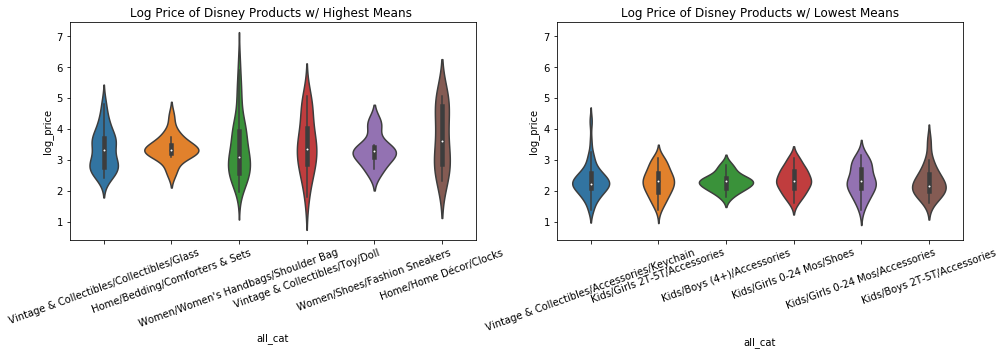

In [33]:
plt.figure(figsize=(16,4))

ax1 = plt.subplot('121')
sns.violinplot(x='all_cat', y='log_price', data=highest)
plt.xticks(rotation=20) 
ax1.set_title('Log Price of Disney Products w/ Highest Means ')

ax2 = plt.subplot('122', sharey=ax1)
sns.violinplot(x='all_cat', y='log_price', data=lowest)
plt.xticks(rotation=20) 
ax2.set_title('Log Price of Disney Products w/ Lowest Means')

plt.show()

### Text Variable - Name & Item Description
It is challenging to parse through item description it's unstructured data written by customers. A more detailed and lengthy description does not necessarily indicate a higher bidding price. We will strip out all punctuations, remove stop words and any words less than 3 alphabets.

In [34]:
print("There are %d missing values item description." % train.item_description.isnull().sum())

# remove missing values in item description
train = train[pd.notnull(train['item_description'])]

There are 4 missing values item description.


#### *Length of Description*

In [35]:
from sklearn.feature_extraction import stop_words
import re

def wordCount(text):
    # convert to lower case and strip regex
    try:
         # convert to lower case and strip regex
        text = text.lower()
        regex = re.compile('[' +re.escape(string.punctuation) + '0-9\\r\\t\\n]')
        txt = regex.sub(" ", text)
        
        # remove words in stop words
        words = [w for w in txt.split(" ") if not w in stop_words.ENGLISH_STOP_WORDS and len(w)>3]
        return len(words)
    except: 
        return 0

In [36]:
%%time
# add a column of word counts to both the training and test set
train['desc_len'] = train['item_description'].apply(lambda x: wordCount(x))
test['desc_len'] = test['item_description'].apply(lambda x: wordCount(x))

CPU times: user 49.6 s, sys: 338 ms, total: 50 s
Wall time: 50.3 s


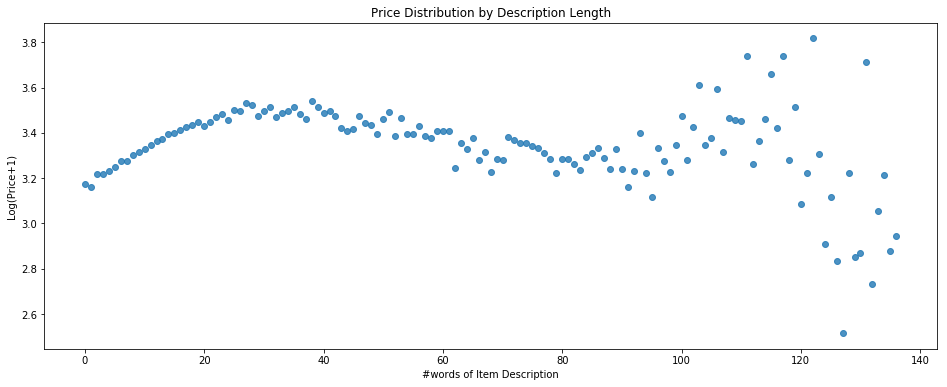

In [37]:
len_mean = train.groupby('desc_len')['price'].mean().reset_index()

plt.figure(figsize=(16,6))
sns.regplot(x=len_mean.desc_len, y=np.log(len_mean.price+1), fit_reg=False)
plt.xlabel('#words of Item Description')
plt.ylabel('Log(Price+1)')
plt.title('Price Distribution by Description Length')
plt.show()

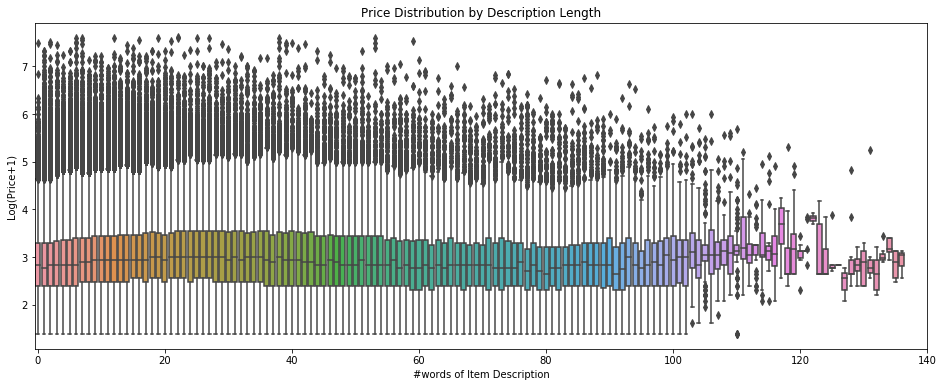

In [38]:
plt.figure(figsize=(16,6))
sns.boxplot(x=train.desc_len, y=train.log_price)
plt.xlabel('#words of Item Description')
plt.ylabel('Log(Price+1)')
plt.title('Price Distribution by Description Length')
plt.xticks((0,20,40,60,80,100,120,140),(0,20,40,60,80,100,120,140))
plt.show()

#### *Fill & replace missing description*

In [83]:
# Fill null w/ spaces
train['item_description'] = train['item_description'].fillna(value=' ')
test['item_description'] = test['item_description'].fillna(value=' ')

# Replace "No description yet" w/ spaces
train['item_description'] = train['item_description'].replace('No description yet', ' ')
test['item_description'] = test['item_description'].replace('No description yet', ' ')

#### *Tokenize*
Steps:
1. full description are tokenized into sentences (remove punctuations)
2. sentences are tokenized into words
3. English stopwords are removed
4. check if alphabet exist in word
5. short words (word length < 3) are removed
6. all words are lower cased

In [67]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

stop = set(stopwords.words('english'))

def tokenize(text):
    """
    sent_tokenize(): segment text into sentences
    word_tokenize(): break sentences into words
    """
    try: 
        regex = re.compile('[' +re.escape(string.punctuation) + '0-9\\r\\t\\n]')
        text = regex.sub(" ", text) # remove punctuation
        
        tokens_ = [word_tokenize(s) for s in sent_tokenize(text)]
        tokens = []
        for token_by_sent in tokens_:
            tokens += token_by_sent
        tokens = list(filter(lambda t: t.lower() not in stop, tokens))
        filtered_tokens = [w for w in tokens if re.search('[a-zA-Z]', w)]
        filtered_tokens = [w.lower() for w in filtered_tokens if len(w)>=3]
        
        return filtered_tokens
            
    except TypeError as e: print(text,e)

In [84]:
raw_text = train.item_description.str.lower() + ' ' + \
           train.name.str.lower() + ' ' + \
           train.category_name.str.lower() + ' ' + \
           train.brand_name.str.lower()

In [74]:
%%time
raw_text = train.item_description.str.lower() + \
           train.name.str.lower() + \
           train.category_name.str.lower() + \
           train.brand_name.str.lower()

tokenized_text = pd.Series(raw_text).map(tokenize)

nan expected string or bytes-like object
nan expected string or bytes-like object
nan expected string or bytes-like object
nan expected string or bytes-like object
nan expected string or bytes-like object
nan expected string or bytes-like object
nan expected string or bytes-like object
nan expected string or bytes-like object
nan expected string or bytes-like object
nan expected string or bytes-like object
nan expected string or bytes-like object
nan expected string or bytes-like object
nan expected string or bytes-like object
nan expected string or bytes-like object
nan expected string or bytes-like object
nan expected string or bytes-like object
nan expected string or bytes-like object
nan expected string or bytes-like object
nan expected string or bytes-like object
nan expected string or bytes-like object
nan expected string or bytes-like object
nan expected string or bytes-like object
nan expected string or bytes-like object
nan expected string or bytes-like object
nan expected str

KeyboardInterrupt: 

In [75]:
raw_text.head()

0    missingmlb cincinnati reds t shirt size xlmen/...
1    this keyboard is in great condition and works ...
2    adorable top with a hint of lace and a key hol...
3    new with tags. leather horses. retail for [rm]...
4    complete with certificate of authenticity24k g...
dtype: object

In [76]:
tokenized_text.head()

0                                            [missing]
1    [keyboard, great, condition, works, like, came...
2    [adorable, top, hint, lace, key, hole, back, p...
3    [new, tags, leather, horses, retail, stand, fo...
4                [complete, certificate, authenticity]
dtype: object

In [ ]:
%%time
raw_text_train = np.hstack([train['item_description'].str.lower(), \
                      train['name'].str.lower(), \
                      train['category_name'].str.lower(),\
                      train['brand_name'].str.lower()])

tokenized_text_train = pd.Series(raw_text_train).map(tokenize)

raw_text_test = np.hstack([test['item_description'].str.lower(), \
                      test['name'].str.lower(), \
                      test['category_name'].str.lower(),\
                      test['brand_name'].str.lower()])

tokenized_text_test = pd.Series(raw_text_test).map(tokenize)

In [51]:
%%time

train['tokens'] = train['item_description'].map(tokenize)
test['tokens'] = test['item_description'].map(tokenize)

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

train.head(3)

CPU times: user 8min 59s, sys: 2.29 s, total: 9min 1s
Wall time: 9min 2s


#### *TF-IDF Preprocessing*
Let's create a tf-idf vectorizer to convert text into vectors. While vectorizing, we will use 2-gram to generate some new vectors.

In [52]:
%%time

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=10, max_features=180000, tokenizer=tokenize, ngram_range=(1, 2))

all_desc = np.append(train['item_description'].values, test['item_description'].values)

CPU times: user 35.7 ms, sys: 3.63 ms, total: 39.4 ms
Wall time: 36.1 ms


In [ ]:
%%time
vz = vectorizer.fit_transform(list(all_desc))

In [ ]:
vz.toarray().shape

In [ ]:
#  create a dictionary mapping the tokens to their tfidf values
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(dict(tfidf), orient='index')
tfidf.columns = ['tfidf']

10 tokens w/ lowest tf-idfs

In [ ]:
tfidf.sort_values(by=['tfidf'], ascending=False).head(10)

10 tokens w/ highest tf-idfs

In [ ]:
tfidf.sort_values(by=['tfidf'], ascending=False).tail(10)

Given the high dimension of our tfidf matrix, we need to reduce their dimension using the Singular Value Decomposition (SVD) technique. And to visualize our vocabulary, we could next use t-SNE to reduce the dimension from 50 to 2.

#### *Wordcloud*
Let's visualize wordclouds for 4 most popular general categories.

In [40]:
from wordcloud import WordCloud

def generate_wordcloud(tup):
    wordcloud = WordCloud(background_color='white', max_words=50, max_font_size=40, random_state=42).generate(str(tup))
    return wordcloud

In [41]:
%%time
from collections import Counter

# build dictionary with key=category and values as all the descriptions related.
general_cats = train['general_cat'].unique()
cat_desc = dict()
for cat in general_cats: 
    text = " ".join(train.loc[train['general_cat']==cat, 'item_description'].values)
    cat_desc[cat] = tokenize(text)


# find the most common words for the top 4 categories
women100 = Counter(cat_desc['Women']).most_common(100)
beauty100 = Counter(cat_desc['Beauty']).most_common(100)
kids100 = Counter(cat_desc['Kids']).most_common(100)
electronics100 = Counter(cat_desc['Electronics']).most_common(100)

CPU times: user 3min 21s, sys: 5.65 s, total: 3min 27s
Wall time: 3min 27s


Text(0.5,1,'Electronic Top 100')

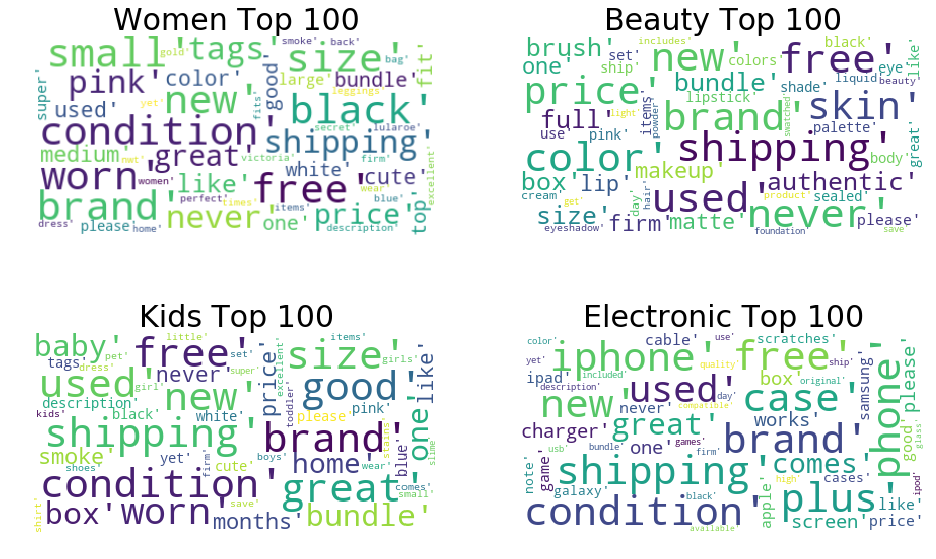

In [42]:
fig,axes = plt.subplots(2, 2, figsize=(16, 10))

ax = axes[0, 0]
ax.imshow(generate_wordcloud(women100), interpolation="bilinear")
ax.axis('off')
ax.set_title("Women Top 100", fontsize=30)

ax = axes[0, 1]
ax.imshow(generate_wordcloud(beauty100))
ax.axis('off')
ax.set_title("Beauty Top 100", fontsize=30)

ax = axes[1, 0]
ax.imshow(generate_wordcloud(kids100))
ax.axis('off')
ax.set_title("Kids Top 100", fontsize=30)

ax = axes[1, 1]
ax.imshow(generate_wordcloud(electronics100))
ax.axis('off')
ax.set_title("Electronic Top 100", fontsize=30)

#### t-SNE for Visualization
t-SNE (t-distributed stochastic neighbor embedding) is a dimensionality reduction technique that is particularly well suited for the visualization of high-dimensional datasets. The goal is to take a set of points in a high-dimensional space and find a representation of those points in a lower-dimensional space. It is based on probability distributions with random walk on neighborhood graphs to find the structure within the data. 

Because t-SNE complexity is significantly high, usually we'd use other high-dimension reduction techniques before applying t-SNE. We will take a sample from the both training and testing item's description since t-SNE can take a very long time to execute. Then reduce the dimension of each vector from thousands to n_components (50) using SVD.

In [ ]:
trn = train.copy()
tst = test.copy()
trn['is_train'] = 1
tst['is_train'] = 0

# take a sub-sample from the dataset
sample_sz = 15000

combined_df = pd.concat([trn, tst])
combined_sample = combined_df.sample(n=sample_sz)

vectorizer2 = TfidfVectorizer(min_df=10, max_features=180000, tokenizer=tokenize, ngram_range=(1, 2))
vz_sample = vectorizer2.fit_transform(list(combined_sample['item_description']))

In [ ]:
vz_sample.toarray().shape

#### Calculate svd to choose n_components for TruncatedSVD

In [ ]:
%%time
U, s, Vh = np.linalg.svd(vz_sample.toarray(), full_matrices=True)
s

In [ ]:
plt.plot(s)
plt.xlim(0,100)
plt.show()

In [ ]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=30, random_state=42)
svd_tfidf = svd.fit_transform(vz_sample)

In [ ]:
svd_tfidf.shape

#### Use t-SNE to further reduce dimensions from 30 to 2 for visualization.

In [ ]:
%%time
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=1, random_state=42, n_iter=500)
tsne_tfidf = tsne_model.fit_transform(svd_tfidf)

In [ ]:
tsne_tfidf.shape

In [ ]:
import bokeh.plotting as bp
from bokeh.plotting import output_notebook

output_notebook()
plot_tfidf = bp.figure(plot_width=700, plot_height=600,
                       title="tf-idf clustering of the item description",
                       tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
                       x_axis_type=None, y_axis_type=None, min_border=1)

In [ ]:
combined_sample.reset_index(inplace=True, drop=True)

tfidf_df = pd.DataFrame(tsne_tfidf, columns=['x', 'y'])
tfidf_df['description'] = combined_sample['item_description']
tfidf_df['tokens'] = combined_sample['tokens']
tfidf_df['category'] = combined_sample['general_cat']

tfidf_df.head()

In [ ]:
from bokeh.models import HoverTool
from bokeh.plotting import show

plot_tfidf.scatter(x='x', y='y', source=tfidf_df, alpha=0.7)
hover = plot_tfidf.select(dict(type=HoverTool))
hover.tooltips={"description": "@description", "tokens": "@tokens", "category":"@category"}
show(plot_tfidf)

After visualizing the 2-d scatterplot with t-SNE, we want to use k-Means to find their clusters.

## Modeling
### K-Means

K-means clustering obejctive is to minimize the average squared Euclidean distance of the document / description from their cluster centroids. We will use MiniBatchKMeans here because it can significantly reduce the time required for the algorithm to find convergence (i.e. fit the data) with only a small cost in quality.

The difference is that in mini-batch k-means the most computationally costly step is conducted on only a random sample of observations as opposed to all observations. The parameter batch_size controls the number of randomly selected observations in each batch. The larger the the size of the batch, the more computationally costly the training process.

Use Elbow method to find optimal number of clusters

In [ ]:
%%time
Nc = range(1, 30)
kmeans = [MiniBatchKMeans(n_clusters=i) for i in Nc]
score = [kmeans[i].fit(vz_sample).score(vz_sample) for i in range(len(kmeans))]

plt.plot(Nc,score)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

In [ ]:
from sklearn.cluster import MiniBatchKMeans

num_clusters = 30 # need to be selected wisely
kmeans_model = MiniBatchKMeans(n_clusters=num_clusters,
                               init='k-means++',
                               n_init=1,
                               init_size=1000, batch_size=1000, verbose=0, max_iter=1000)

In [ ]:
vz.shape

In [ ]:
%%time
kmeans = kmeans_model.fit(vz)
kmeans_clusters = kmeans.predict(vz)
kmeans_distances = kmeans.transform(vz)

In [ ]:
sorted_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

In [ ]:
30 centroids in 180000 token-dimension

In [ ]:
for i in range(num_clusters):
    print("Cluster %d:" % i)
    aux = ''
    for j in sorted_centroids[i, :10]:
        print(j)
        aux += terms[k] + ' | '
    print(aux)

#### In order to plot these clusters, we will need to reduce the dimension of the distances to 2 using tsne.

In [ ]:
%%time
# repeat the same steps for the sample
kmeans = kmeans_model.fit(vz_sample)
kmeans_clusters = kmeans.predict(vz_sample)
kmeans_distances = kmeans.transform(vz_sample)
# reduce dimension to 2 using tsne
tsne_kmeans = tsne_model.fit_transform(kmeans_distances)

In [ ]:
colormap = np.array(["#6d8dca", "#69de53", "#723bca", "#c3e14c", "#c84dc9", "#68af4e", "#6e6cd5",
"#e3be38", "#4e2d7c", "#5fdfa8", "#d34690", "#3f6d31", "#d44427", "#7fcdd8", "#cb4053", "#5e9981",
"#803a62", "#9b9e39", "#c88cca", "#e1c37b", "#34223b", "#bdd8a3", "#6e3326", "#cfbdce", "#d07d3c",
"#52697d", "#194196", "#d27c88", "#36422b", "#b68f79"])

In [ ]:
#combined_sample.reset_index(drop=True, inplace=True)
kmeans_df = pd.DataFrame(tsne_kmeans, columns=['x', 'y'])
kmeans_df['cluster'] = kmeans_clusters
kmeans_df['description'] = combined_sample['item_description']
kmeans_df['category'] = combined_sample['general_cat']
#kmeans_df['cluster']=kmeans_df.cluster.astype(str).astype('category')

In [ ]:
plot_kmeans = bp.figure(plot_width=700, plot_height=600,
                        title="KMeans clustering of the description",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

In [ ]:
from bokeh.models import ColumnDataSource

source = ColumnDataSource(data=dict(x=kmeans_df['x'], y=kmeans_df['y'],
                                    color=colormap[kmeans_clusters],
                                    description=kmeans_df['description'],
                                    category=kmeans_df['category'],
                                    cluster=kmeans_df['cluster']))

plot_kmeans.scatter(x='x', y='y', color='color', source=source)
hover = plot_kmeans.select(dict(type=HoverTool))
hover.tooltips={"description": "@description", "category": "@category", "cluster":"@cluster" }
show(plot_kmeans)

#### *Topic analysis*
The tf-idf method only consider the words. The logic relationship and order between the words are neglected. Let's use a topic based method (Latent Dirichlet Allocation) to refine our analysis.

https://blog.csdn.net/aws3217150/article/details/53840029

http://www.mamicode.com/info-detail-1600475.html

https://www.cnblogs.com/huangshiyu13/p/6148217.html

### Neural Network

In [5]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


So far we have following variables:

- Numerical var (target): log_price
- Categorical var: shipping cost
- Categorical var: condition
- Categorical/text: name

#### *Label Encoding*

In [ ]:
%%time

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

full_df = pd.concat([train, test])

le.fit(full_df['category_name'])
train['category'] = le.transform(train['category_name'])
test['category'] = le.transform(test.category_name)

le.fit(full_df['brand_name'])
train['brand_name'] = le.transform(train['brand_name'])
test['brand_name'] = le.transform(test['brand_name'])

del le

## Ensemble Method